In [1]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import dill
from transformers import BertTokenizer, BertModel
import struct
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import itertools
import numpy as np
from om.match import onts, aligns, Step, Runner
from om.ont import get_n, tokenize
from rdflib import Graph
from rdflib.term import URIRef, Literal, BNode
from rdflib.namespace import RDF, RDFS, OWL
from termcolor import colored
from py_stringmatching import Levenshtein, SoftTfIdf, JaroWinkler
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re
from sklearn.model_selection import KFold
from utils import gn, pad_encode, metrics
from datasets import build_dataset1, build_dataset2
from models import Finbank, Model1, Model2
from property_matching import is_property, PropertyMatcher
from sentence_transformers import SentenceTransformer
import numpy
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [22]:
l, x, y = build_dataset1('/projets/melodi/gsantoss/data/yago/yago-class.nt',
                         '/projets/melodi/gsantoss/data/yago/yago-schema.nt',
                         '/projets/melodi/gsantoss/data/semclass1.pyo')



tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
x1 = tokenizer(x, return_tensors='pt', padding=True)
x1_ids = x1['input_ids']
x1_attention_mask = x1['attention_mask']
vocab = set(itertools.chain(*(list(map(str.split, l)) + list(map(str.split, x)))))
word_index = {q: (i + 1) for i, q in enumerate(vocab)}
l2 = pad_encode(l, word_index)
x2 = pad_encode(x, word_index)

print(l2.shape, x2.shape)
dataset = list(zip(x1_ids, x1_attention_mask, l2, x2, y))
print(len(dataset))


10148
torch.Size([8063, 9]) torch.Size([8063, 70])
8063


In [23]:

crit = nn.NLLLoss()

model1 = Model1(6)
model1.cuda(0)

optimizer1 = optim.Adam(model1.parameters(), lr=0.00003)

for x1i, x1a, x2l, x2x, y in DataLoader(dataset, batch_size=32, shuffle=True):
    optimizer1.zero_grad()

    out1 = model1(x1i.cuda(0), x1a.cuda(0)).cpu()

    l1 = crit(out1, y)
    l1.backward()


    optimizer1.step()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
lev = Levenshtein()

In [25]:
def match_class(o1, o2, th):
    correct = [0] * len(th)
    pred = [0] * len(th)
    total = 0
    iterations = 0
    for r, k1, k2 in onts(o1, o2):

        print('-' * 100)
        print(k1.split('/')[-1], k2.split('/')[-1])

        o1 = Graph().parse(k1)
        o2 = Graph().parse(k2)

        als = set(aligns(r))

        pa = set()

        for a1, a2 in als:

            if not is_property(a1, o1) and not is_property(a2, o2):
                total += 1
                pa.add((a1, a2))

                print(colored('#', 'blue'), get_n(a1, o1), colored('<>', 'green'), get_n(a2, o2))

        p = set()
        oi = 0

        for e1 in set(o1.subjects()):
            if is_property(e1, o1) or type(e1) is BNode:
                continue
            for e2 in set(o2.subjects()):
                if is_property(e2, o2) or type(e2) is BNode:
                    continue

                oi += 1
                iterations += 1
                sim = lev.get_sim_score(get_n(e1, o1).lower(), get_n(e2, o2).lower())
                p.add((e1, e2, sim))

        for i, t in enumerate(th):
            pt = set(map(lambda x: (x[0], x[1]), filter(lambda y: y[2] >= t, p)))
            pred[i] += len(pt)
            correct[i] += len(pa.intersection(pt))


        print('ontology iterations:', oi)


    return [metrics(c, p, total) for c, p in zip(correct, pred)]




In [26]:
match_class('/projets/melodi/gsantoss/data/conference', '/projets/melodi/gsantoss/data/reference', [0.85])


----------------------------------------------------------------------------------------------------
cmt.owl Conference.owl
# ProgramCommittee <> Program_committee
# Conference <> Conference
# Conference <> Conference_volume
# Chairman <> Chair
# SubjectArea <> Topic
# Person <> Person
# Co-author <> Contribution_co-author
# Preference <> Review_preference
# PaperAbstract <> Abstract
# Document <> Conference_document
# Author <> Regular_author
# Review <> Review
ontology iterations: 1800
----------------------------------------------------------------------------------------------------
confOf.owl iasted.owl
# Country <> State
# Banquet <> Dinner_banquet
# Tutorial <> Tutorial
# Reception <> Coctail_reception
# Person <> Person
# Author <> Author
# Administrative_event <> Activity_before_conference
# Event <> Activity
# City <> City
ontology iterations: 5655
----------------------------------------------------------------------------------------------------
edas.owl sigkdd.owl
# Place 

[(0.8780487804878049, 0.5581395348837209, 0.6824644549763034)]

In [27]:
lvit = match_class('/projets/melodi/gsantoss/data/conference', '/projets/melodi/gsantoss/data/reference', numpy.arange(0, 0.95, 0.05))

----------------------------------------------------------------------------------------------------
cmt.owl Conference.owl
# ProgramCommittee <> Program_committee
# Conference <> Conference
# Conference <> Conference_volume
# Chairman <> Chair
# SubjectArea <> Topic
# Person <> Person
# Co-author <> Contribution_co-author
# Preference <> Review_preference
# PaperAbstract <> Abstract
# Document <> Conference_document
# Author <> Regular_author
# Review <> Review
ontology iterations: 1800
----------------------------------------------------------------------------------------------------
confOf.owl iasted.owl
# Country <> State
# Banquet <> Dinner_banquet
# Tutorial <> Tutorial
# Reception <> Coctail_reception
# Person <> Person
# Author <> Author
# Administrative_event <> Activity_before_conference
# Event <> Activity
# City <> City
ontology iterations: 5655
----------------------------------------------------------------------------------------------------
edas.owl sigkdd.owl
# Place 

In [28]:
def match_classes_with_model_filter(o1, o2, tokenizer, model, th):
    correct = [0] * len(th)
    pred = [0] * len(th)
    total = 0
    iterations = 0
    for r, k1, k2 in onts(o1, o2):


        print('-' * 100)
        print(k1.split('/')[-1], k2.split('/')[-1])

        o1 = Graph().parse(k1)
        o2 = Graph().parse(k2)

        als = set(aligns(r))

        pa = set()

        for a1, a2 in als:

            if not is_property(a1, o1) and not is_property(a2, o2):
                total += 1
                pa.add((a1, a2))

                print(colored('#', 'blue'), get_n(a1, o1), colored('<>', 'green'), get_n(a2, o2))

        p1 = []

        for e1 in set(o1.subjects()):
            if is_property(e1, o1) or type(e1) is BNode:
                continue

            p1.append(e1)

        p2 = []

        for e2 in set(o2.subjects()):
            if is_property(e2, o2) or type(e2) is BNode:
                continue

            p2.append(e2)

        p1d = [' '.join(map(str.lower, tokenize(get_n(x, o1)))) for x in p1]
        p2d = [' '.join(map(str.lower, tokenize(get_n(x, o2)))) for x in p2]

        tk = tokenizer(p1d, return_tensors='pt', padding=True)

        idx = tk['input_ids']
        atn = tk['attention_mask']

        with torch.no_grad():
            out1 = model(idx.cuda(0), atn.cuda(0)).exp().cpu()

        tk = tokenizer(p2d, return_tensors='pt', padding=True)

        idx = tk['input_ids']
        atn = tk['attention_mask']

        with torch.no_grad():
            out2 = model(idx.cuda(0), atn.cuda(0)).exp().cpu()

        cl1 = out1.argmax(dim=1)
        cl2 = out2.argmax(dim=1)
        sim = cl1.unsqueeze(1) == cl2.unsqueeze(0)

        nz = list(map(lambda x: (p1[x[0].item()], p2[x[1].item()]), sim.nonzero()))

        p = set()
        oi = 0
        for step in range(1):

            for e1, e2 in nz:

                oi += 1
                iterations += 1
                sim = lev.get_sim_score(get_n(e1, o1).lower(), get_n(e2, o2).lower())
                p.add((e1, e2, sim))

        for i, t in enumerate(th):
            pt = set(map(lambda x: (x[0], x[1]), filter(lambda y: y[2] >= t, p)))
            pred[i] += len(pt)
            correct[i] += len(pa.intersection(pt))

    print(iterations)
    return [metrics(c, p, total) for c, p in zip(correct, pred)]

model1.eval()
match_classes_with_model_filter('/projets/melodi/gsantoss/data/conference', '/projets/melodi/gsantoss/data/reference', tokenizer, model1, [0.85])

----------------------------------------------------------------------------------------------------
cmt.owl Conference.owl
# ProgramCommittee <> Program_committee
# Conference <> Conference
# Conference <> Conference_volume
# Chairman <> Chair
# SubjectArea <> Topic
# Person <> Person
# Co-author <> Contribution_co-author
# Preference <> Review_preference
# PaperAbstract <> Abstract
# Document <> Conference_document
# Author <> Regular_author
# Review <> Review
----------------------------------------------------------------------------------------------------
confOf.owl iasted.owl
# Country <> State
# Banquet <> Dinner_banquet
# Tutorial <> Tutorial
# Reception <> Coctail_reception
# Person <> Person
# Author <> Author
# Administrative_event <> Activity_before_conference
# Event <> Activity
# City <> City
----------------------------------------------------------------------------------------------------
edas.owl sigkdd.owl
# Place <> Place
# Document <> Document
# Author <> Author
#

[(0.8773006134969326, 0.5542635658914729, 0.6793349168646081)]

In [29]:
md1it = match_classes_with_model_filter('/projets/melodi/gsantoss/data/conference', '/projets/melodi/gsantoss/data/reference', tokenizer, model1, numpy.arange(0, 0.95, 0.05))

----------------------------------------------------------------------------------------------------
cmt.owl Conference.owl
# ProgramCommittee <> Program_committee
# Conference <> Conference
# Conference <> Conference_volume
# Chairman <> Chair
# SubjectArea <> Topic
# Person <> Person
# Co-author <> Contribution_co-author
# Preference <> Review_preference
# PaperAbstract <> Abstract
# Document <> Conference_document
# Author <> Regular_author
# Review <> Review
----------------------------------------------------------------------------------------------------
confOf.owl iasted.owl
# Country <> State
# Banquet <> Dinner_banquet
# Tutorial <> Tutorial
# Reception <> Coctail_reception
# Person <> Person
# Author <> Author
# Administrative_event <> Activity_before_conference
# Event <> Activity
# City <> City
----------------------------------------------------------------------------------------------------
edas.owl sigkdd.owl
# Place <> Place
# Document <> Document
# Author <> Author
#

In [34]:

wm = Finbank('/projets/melodi/gsantoss/data/embeddings/fb.txt', '/projets/melodi/gsantoss/data/embeddings/fbe.bin')
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

property_matcher = PropertyMatcher(wm, model)

In [35]:
property_matcher.match_with_model_filter('/projets/melodi/gsantoss/data/conference', '/projets/melodi/gsantoss/data/reference', tokenizer, model1)


----------------------------------------------------------------------------------------------------
cmt.owl Conference.owl
# ExternalReviewer assignedByReviewer Reviewer <> Reviewer invited_by Reviewer
# Reviewer assignExternalReviewer ExternalReviewer <> Reviewer invites_co-reviewers Reviewer
# Person email string <> Person has_an_email string
✓ email has_an_email
ontology iterations: 1368
----------------------------------------------------------------------------------------------------
confOf.owl iasted.owl
ontology iterations: 418
----------------------------------------------------------------------------------------------------
edas.owl sigkdd.owl
# Conference hasName string <> Conference Name_of_conference string
# Sponsorship hasCostAmount int <> Registration_fee Price int
# Conference startDate dateTime <> Conference Start_of_conference dateTime
# Conference endDate dateTime <> Conference End_of_conference dateTime
✓ startDate Start_of_conference
✓ endDate End_of_conference


In [30]:
l, x, y = build_dataset1('/projets/melodi/gsantoss/data/yago/yago-class.nt',
                         '/projets/melodi/gsantoss/data/yago/yago-schema.nt',
                         '/projets/melodi/gsantoss/data/semclass1.pyo')



l1 = tokenizer(l, return_tensors='pt', padding=True)
x1_ids = l1['input_ids']
x1_attention_mask = l1['attention_mask']

dataset = list(zip(x1_ids, x1_attention_mask, y))

10148


In [31]:
model1.eval()

out1 = []
out2 = []
with torch.no_grad():
    for x1i, x1a, y in DataLoader(dataset, batch_size=64, shuffle=True):
        o1 = model1(x1i.cuda(0), x1a.cuda(0)).exp().cpu()
        out1.append(o1.argmax(dim=1) == y)


out1 = torch.cat(out1).float()
acc1 = out1.sum() / out1.shape[0]
print(acc1.item())

0.7701848149299622


In [32]:
c, x, y = build_dataset2('/projets/melodi/gsantoss/data/dataset2.csv')
x1 = tokenizer(list(x), return_tensors='pt', padding=True)
x1_ids = x1['input_ids']
x1_attention_mask = x1['attention_mask']
print(x1_ids.shape)
vocab = set(itertools.chain(*(list(map(str.split, c)) + list(map(str.split, x)))))

word_index = {q: (i + 1) for i, q in enumerate(vocab)}
print(len(word_index))
l2 = pad_encode(c, word_index)
x2 = pad_encode(x, word_index)

print(l2.shape, x2.shape)
dataset = list(zip(x1_ids, x1_attention_mask, l2, x2, y))
print(len(dataset))



4035
torch.Size([20175, 13])
31036
torch.Size([20175, 79]) torch.Size([20175, 7])
20175


In [33]:

crit = nn.NLLLoss()

model2 = Model1(5)
model2.cuda(0)
optimizer1 = optim.Adam(model2.parameters(), lr=0.00003)

for x1i, x1a, x2l, x2x, y in DataLoader(dataset, batch_size=32, shuffle=True):
    optimizer1.zero_grad()

    out1 = model2(x1i.cuda(0), x1a.cuda(0)).cpu()

    l1 = crit(out1, y)
    l1.backward()

    optimizer1.step()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
model2.eval()
match_classes_with_model_filter('/projets/melodi/gsantoss/data/conference', '/projets/melodi/gsantoss/data/reference', tokenizer, model2, [0.85])

----------------------------------------------------------------------------------------------------
cmt.owl Conference.owl
# ProgramCommittee <> Program_committee
# Conference <> Conference
# Conference <> Conference_volume
# Chairman <> Chair
# SubjectArea <> Topic
# Person <> Person
# Co-author <> Contribution_co-author
# Preference <> Review_preference
# PaperAbstract <> Abstract
# Document <> Conference_document
# Author <> Regular_author
# Review <> Review
----------------------------------------------------------------------------------------------------
confOf.owl iasted.owl
# Country <> State
# Banquet <> Dinner_banquet
# Tutorial <> Tutorial
# Reception <> Coctail_reception
# Person <> Person
# Author <> Author
# Administrative_event <> Activity_before_conference
# Event <> Activity
# City <> City
----------------------------------------------------------------------------------------------------
edas.owl sigkdd.owl
# Place <> Place
# Document <> Document
# Author <> Author
#

[(0.8742138364779874, 0.5387596899224806, 0.6666666666666666)]

In [35]:
md2it = match_classes_with_model_filter('/projets/melodi/gsantoss/data/conference', '/projets/melodi/gsantoss/data/reference', tokenizer, model2, numpy.arange(0, 0.95, 0.05))

----------------------------------------------------------------------------------------------------
cmt.owl Conference.owl
# ProgramCommittee <> Program_committee
# Conference <> Conference
# Conference <> Conference_volume
# Chairman <> Chair
# SubjectArea <> Topic
# Person <> Person
# Co-author <> Contribution_co-author
# Preference <> Review_preference
# PaperAbstract <> Abstract
# Document <> Conference_document
# Author <> Regular_author
# Review <> Review
----------------------------------------------------------------------------------------------------
confOf.owl iasted.owl
# Country <> State
# Banquet <> Dinner_banquet
# Tutorial <> Tutorial
# Reception <> Coctail_reception
# Person <> Person
# Author <> Author
# Administrative_event <> Activity_before_conference
# Event <> Activity
# City <> City
----------------------------------------------------------------------------------------------------
edas.owl sigkdd.owl
# Place <> Place
# Document <> Document
# Author <> Author
#

In [36]:
property_matcher.match_with_model_filter('/projets/melodi/gsantoss/data/conference', '/projets/melodi/gsantoss/data/reference', tokenizer, model2)

NameError: name 'property_matcher' is not defined

In [37]:
c, x, y = build_dataset2('/projets/melodi/gsantoss/data/dataset2.csv')
x1 = tokenizer(list(c), return_tensors='pt', padding=True)
x1_ids = x1['input_ids']
x1_attention_mask = x1['attention_mask']
print(x1_ids.shape)

dataset = list(zip(x1_ids, x1_attention_mask, y))
print(len(dataset))



4035
torch.Size([20175, 96])
20175


In [38]:
model2.eval()

out1 = []
out2 = []
with torch.no_grad():
    for x1i, x1a, y in DataLoader(dataset, batch_size=64, shuffle=True):
        o1 = model2(x1i.cuda(0), x1a.cuda(0)).exp().cpu()
        out1.append(o1.argmax(dim=1) == y)


out1 = torch.cat(out1).float()
acc1 = out1.sum() / out1.shape[0]
print(acc1.item())

0.7373977899551392


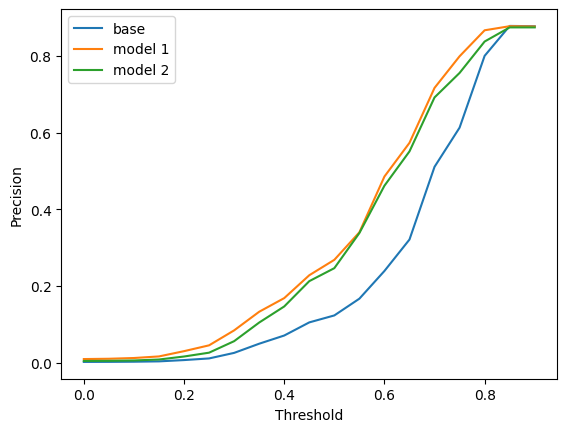

In [39]:


plt.plot(numpy.arange(0, 0.95, 0.05), list(map(lambda x: x[0], lvit)), label="base")
plt.plot(numpy.arange(0, 0.95, 0.05), list(map(lambda x: x[0], md1it)), label="model 1")
plt.plot(numpy.arange(0, 0.95, 0.05), list(map(lambda x: x[0], md2it)), label="model 2")
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.savefig('prec.png', dpi=300)



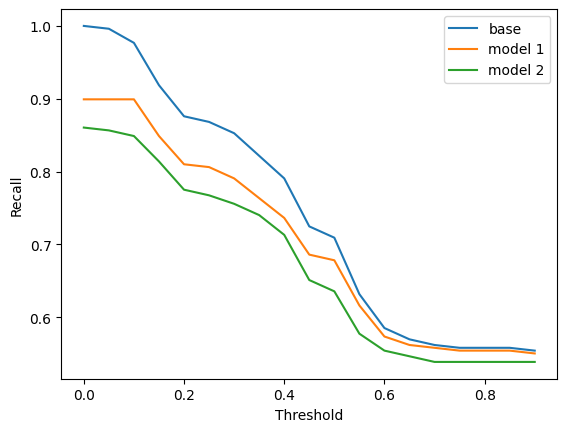

In [40]:
plt.plot(numpy.arange(0, 0.95, 0.05), list(map(lambda x: x[1], lvit)), label="base")
plt.plot(numpy.arange(0, 0.95, 0.05), list(map(lambda x: x[1], md1it)), label="model 1")
plt.plot(numpy.arange(0, 0.95, 0.05), list(map(lambda x: x[1], md2it)), label="model 2")
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.savefig('rec.png', dpi=300)


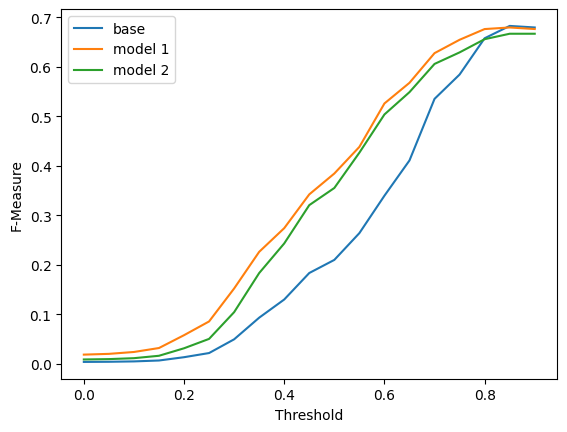

In [41]:
plt.plot(numpy.arange(0, 0.95, 0.05), list(map(lambda x: x[2], lvit)), label="base")
plt.plot(numpy.arange(0, 0.95, 0.05), list(map(lambda x: x[2], md1it)), label="model 1")
plt.plot(numpy.arange(0, 0.95, 0.05), list(map(lambda x: x[2], md2it)), label="model 2")
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('F-Measure')
plt.savefig('fmeasure.png', dpi=300)